In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from strategy_tester import Backtesting
from model_loader import ModelLoader
from sklearn.metrics import classification_report

/home/toyotx22/bitcoin_sentiment_forecaster/tf_venv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def trend_changes_score(y_true: np.array, y_pred: np.array) -> str:
    """
    Calcula el reporte de clasificación para los cambios de tendencia.
    """
    y_df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    y_df["y_true_shifted"] = y_df["y_true"].shift(-1)
    y_df["is_changed_trend_true"] = y_df["y_true"] != y_df["y_true_shifted"]
    y_df["y_pred_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_pred"] = y_df["y_pred"] != y_df["y_pred_shifted"]
    
    # Se elimina la última fila que tendrá NaN
    y_df = y_df.dropna()
    
    return classification_report(
        y_df["is_changed_trend_true"], 
        y_df["is_changed_trend_pred"], 
        digits=4,
        zero_division=0
    )

In [3]:
# Leer el archivo de métricas
metrics_path = '../../score_models/model_comparison_metrics.csv'
df = pd.read_csv(metrics_path, index_col='model')

# Encontrar el modelo con el mayor trend_change_f1_score
best_model_name = df['trend_change_f1_score'].idxmax()
print(f"Mejor modelo según trend_change_f1_score: {best_model_name}")

# Construir la ruta del archivo del modelo
model_file = f'../../score_models/{best_model_name}.txt'

# Instanciar y cargar el modelo
loader = ModelLoader(best_model_name, model_file)
model = loader.load()
params = model.params


Mejor modelo según trend_change_f1_score: LightGBM


In [4]:
# Cargar datos
train = pd.read_csv("../../data/post_cleaning/training_set.csv", parse_dates=["date"])
val = pd.read_csv("../../data/post_cleaning/validation_set.csv", parse_dates=["date"])
test_set = pd.read_csv("../../data/post_cleaning/test_set.csv", parse_dates=['date'])

# --- MODIFICACIÓN: Limitar el test set si es necesario ---
# Para pruebas rápidas, puedes limitar el número de días. Para un backtest completo, usa todos los datos.
# n_days_to_test = 50 
# test_set = test_set_full.head(n_days_to_test).copy()

# Preparar los arrays de numpy para la clase Backtesting
X_train = train.drop(columns=["date", "target_trend"]).values
y_train = train["target_trend"].values
X_val = val.drop(columns=["date", "target_trend"]).values
y_val = val["target_trend"].values
X_test = test_set.drop(columns=['target_trend','date']).values
y_test = test_set['target_trend'].values

In [5]:
# --- Ejecución del Backtesting con Walk-Forward Optimization ---

# 1. Configuración
initial_capital = 10000.0
window_size = 5
optuna_trials_initial_step = 700 # Número de trials de Optuna en el primer paso de re-optimización
optuna_trials_per_step = 100

# 2. Instanciar y ejecutar el backtesting
# La clase se encarga de todo el proceso de Walk-Forward Optimization
bt = Backtesting(
    X_train, y_train, X_val, y_val, X_test, y_test, test_set,
    window_size=window_size,
    initial_capital=initial_capital,
    optuna_trials_initial=optuna_trials_initial_step,
    optuna_trials=optuna_trials_per_step
)

# Ejecutar el método que contiene toda la lógica
backtest_df, price_col, num_buys, num_sells = bt.lightgbm()

# 3. Resultados
final_portfolio_value = backtest_df['portfolio_value'].iloc[-1]
total_return_pct = (final_portfolio_value - initial_capital) / initial_capital * 100
buy_and_hold_return_pct = (backtest_df[price_col].iloc[-1] - backtest_df[price_col].iloc[0]) / backtest_df[price_col].iloc[0] * 100

print("\n--- Resultados del Backtesting (Walk-Forward Optimization) ---")
print(f"Capital Inicial: ${initial_capital:,.2f}")
print(f"Valor Final del Portafolio: ${final_portfolio_value:,.2f}")
print(f"Retorno Total de la Estrategia: {total_return_pct:.2f}%")
print(f"Retorno de Comprar y Mantener (Buy & Hold): {buy_and_hold_return_pct:.2f}%")

Walk-Forward Backtesting:   0%|          | 0/59 [00:00<?, ?it/s][I 2025-09-04 16:06:21,297] A new study created in memory with name: no-name-5015b79f-2350-4523-86de-3a34c0c56cf9
[I 2025-09-04 16:06:27,033] Trial 0 finished with value: 0.24615384615384617 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.24615384615384617.
[I 2025-09-04 16:06:29,007] Trial 1 finished with value: 0.3466666666666667 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 1 with value: 0.3466666666666667.
[I 2025-09-04 16:06:30,578] Trial 2 finished with value: 0.3283582089552239 and parameters: {'learning_rate': 0.017240892195821537, 'num_leave

  -> Fin de la ventana (días 0-4). Valor del Portafolio: $10,000.00
  -> Compras ejecutadas: 0
  -> Ventas ejecutadas: 0


[I 2025-09-04 16:21:14,387] Trial 0 finished with value: 0.34285714285714286 and parameters: {'learning_rate': 0.03499594919916129, 'num_leaves': 93, 'max_depth': 5, 'feature_fraction': 0.6684634198738507, 'bagging_fraction': 0.9532591176185262, 'bagging_freq': 4, 'min_child_samples': 95}. Best is trial 0 with value: 0.34285714285714286.
[I 2025-09-04 16:21:19,411] Trial 1 finished with value: 0.32786885245901637 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.34285714285714286.
[I 2025-09-04 16:21:20,434] Trial 2 finished with value: 0.2894736842105263 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 

  -> Fin de la ventana (días 5-9). Valor del Portafolio: $9,819.24
  -> Compras ejecutadas: 1
  -> Ventas ejecutadas: 0


[I 2025-09-04 16:23:00,091] Trial 0 finished with value: 0.34285714285714286 and parameters: {'learning_rate': 0.10893424216850237, 'num_leaves': 88, 'max_depth': 4, 'feature_fraction': 0.9570085954080748, 'bagging_fraction': 0.7105610340620506, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial 0 with value: 0.34285714285714286.
[I 2025-09-04 16:23:03,190] Trial 1 finished with value: 0.24324324324324326 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.34285714285714286.
[I 2025-09-04 16:23:04,171] Trial 2 finished with value: 0.3466666666666667 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with value: 

  -> Fin de la ventana (días 10-14). Valor del Portafolio: $9,685.26
  -> Compras ejecutadas: 2
  -> Ventas ejecutadas: 1


[I 2025-09-04 16:24:52,151] Trial 0 finished with value: 0.36363636363636365 and parameters: {'learning_rate': 0.13867695877015485, 'num_leaves': 33, 'max_depth': 4, 'feature_fraction': 0.8899047683021124, 'bagging_fraction': 0.739074400759479, 'bagging_freq': 2, 'min_child_samples': 91}. Best is trial 0 with value: 0.36363636363636365.
[I 2025-09-04 16:24:55,110] Trial 1 finished with value: 0.3076923076923077 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.36363636363636365.
[I 2025-09-04 16:24:56,057] Trial 2 finished with value: 0.2972972972972973 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.

  -> Fin de la ventana (días 15-19). Valor del Portafolio: $9,531.12
  -> Compras ejecutadas: 2
  -> Ventas ejecutadas: 1


[I 2025-09-04 16:26:34,934] Trial 0 finished with value: 0.3333333333333333 and parameters: {'learning_rate': 0.10189948350924663, 'num_leaves': 37, 'max_depth': 4, 'feature_fraction': 0.8601280284784317, 'bagging_fraction': 0.7030597066441624, 'bagging_freq': 5, 'min_child_samples': 92}. Best is trial 0 with value: 0.3333333333333333.
[I 2025-09-04 16:26:38,159] Trial 1 finished with value: 0.29850746268656714 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.3333333333333333.
[I 2025-09-04 16:26:39,502] Trial 2 finished with value: 0.36585365853658536 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with value: 0.

  -> Fin de la ventana (días 20-24). Valor del Portafolio: $9,522.14
  -> Compras ejecutadas: 2
  -> Ventas ejecutadas: 2


[I 2025-09-04 16:29:31,153] Trial 0 finished with value: 0.325 and parameters: {'learning_rate': 0.1277803832975784, 'num_leaves': 26, 'max_depth': 10, 'feature_fraction': 0.7929342571283748, 'bagging_fraction': 0.822282859352739, 'bagging_freq': 3, 'min_child_samples': 47}. Best is trial 0 with value: 0.325.
[I 2025-09-04 16:29:33,396] Trial 1 finished with value: 0.2702702702702703 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.325.
[I 2025-09-04 16:29:34,847] Trial 2 finished with value: 0.3448275862068966 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with value: 0.3448275862068966.
[I 2025-09-04 16:29:36,9

  -> Fin de la ventana (días 25-29). Valor del Portafolio: $9,522.14
  -> Compras ejecutadas: 2
  -> Ventas ejecutadas: 2


[I 2025-09-04 16:31:58,493] Trial 0 finished with value: 0.3291139240506329 and parameters: {'learning_rate': 0.18816911159867136, 'num_leaves': 60, 'max_depth': 9, 'feature_fraction': 0.6017034114780485, 'bagging_fraction': 0.9839504642378528, 'bagging_freq': 4, 'min_child_samples': 41}. Best is trial 0 with value: 0.3291139240506329.
[I 2025-09-04 16:32:01,781] Trial 1 finished with value: 0.3561643835616438 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 1 with value: 0.3561643835616438.
[I 2025-09-04 16:32:02,741] Trial 2 finished with value: 0.27848101265822783 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 1 with value: 0.3

  -> Fin de la ventana (días 30-34). Valor del Portafolio: $9,522.14
  -> Compras ejecutadas: 2
  -> Ventas ejecutadas: 2


[I 2025-09-04 16:33:34,743] Trial 0 finished with value: 0.2857142857142857 and parameters: {'learning_rate': 0.10431787356022859, 'num_leaves': 39, 'max_depth': 4, 'feature_fraction': 0.8577575912249142, 'bagging_fraction': 0.7448798581966226, 'bagging_freq': 1, 'min_child_samples': 51}. Best is trial 0 with value: 0.2857142857142857.
[I 2025-09-04 16:33:37,827] Trial 1 finished with value: 0.2857142857142857 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.2857142857142857.
[I 2025-09-04 16:33:38,182] Trial 2 finished with value: 0.3013698630136986 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with value: 0.30

  -> Fin de la ventana (días 35-39). Valor del Portafolio: $9,535.52
  -> Compras ejecutadas: 3
  -> Ventas ejecutadas: 2


[I 2025-09-04 16:35:18,122] Trial 0 finished with value: 0.38461538461538464 and parameters: {'learning_rate': 0.047173266906116625, 'num_leaves': 75, 'max_depth': 5, 'feature_fraction': 0.8294976064377795, 'bagging_fraction': 0.7898162765071596, 'bagging_freq': 6, 'min_child_samples': 73}. Best is trial 0 with value: 0.38461538461538464.
[I 2025-09-04 16:35:21,326] Trial 1 finished with value: 0.2702702702702703 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.38461538461538464.
[I 2025-09-04 16:35:23,354] Trial 2 finished with value: 0.3037974683544304 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 

  -> Fin de la ventana (días 40-44). Valor del Portafolio: $10,376.63
  -> Compras ejecutadas: 3
  -> Ventas ejecutadas: 2


[I 2025-09-04 16:37:40,095] Trial 0 finished with value: 0.3488372093023256 and parameters: {'learning_rate': 0.08740036700377972, 'num_leaves': 42, 'max_depth': 9, 'feature_fraction': 0.7816766383379545, 'bagging_fraction': 0.8899916714912761, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 0 with value: 0.3488372093023256.
[I 2025-09-04 16:37:43,668] Trial 1 finished with value: 0.37333333333333335 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 1 with value: 0.37333333333333335.
[I 2025-09-04 16:37:44,649] Trial 2 finished with value: 0.3013698630136986 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 1 with value: 0.

  -> Fin de la ventana (días 45-49). Valor del Portafolio: $10,675.57
  -> Compras ejecutadas: 3
  -> Ventas ejecutadas: 2


[I 2025-09-04 16:40:15,865] Trial 1 finished with value: 0.2898550724637681 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.35443037974683544.
[I 2025-09-04 16:40:18,078] Trial 2 finished with value: 0.3055555555555556 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.35443037974683544.
[I 2025-09-04 16:40:20,049] Trial 3 finished with value: 0.39473684210526316 and parameters: {'learning_rate': 0.017240892195821537, 'num_leaves': 34, 'max_depth': 6, 'feature_fraction': 0.8099025726528951, 'bagging_fraction': 0.7727780074568463, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 3 with value: 

  -> Fin de la ventana (días 50-54). Valor del Portafolio: $9,959.92
  -> Compras ejecutadas: 3
  -> Ventas ejecutadas: 3


[I 2025-09-04 16:42:36,307] Trial 0 finished with value: 0.375 and parameters: {'learning_rate': 0.045776658173798605, 'num_leaves': 25, 'max_depth': 8, 'feature_fraction': 0.7899857023931112, 'bagging_fraction': 0.7493036668825779, 'bagging_freq': 4, 'min_child_samples': 66}. Best is trial 0 with value: 0.375.
[I 2025-09-04 16:42:40,134] Trial 1 finished with value: 0.36363636363636365 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.375.
[I 2025-09-04 16:42:41,196] Trial 2 finished with value: 0.3291139240506329 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.375.
[I 2025-09-04 16:42:42,835] Trial 

  -> Fin de la ventana (días 55-59). Valor del Portafolio: $9,959.92
  -> Compras ejecutadas: 3
  -> Ventas ejecutadas: 3


[I 2025-09-04 16:44:35,212] Trial 0 finished with value: 0.3684210526315789 and parameters: {'learning_rate': 0.050678061954986815, 'num_leaves': 51, 'max_depth': 11, 'feature_fraction': 0.7365408631898037, 'bagging_fraction': 0.602666449178521, 'bagging_freq': 3, 'min_child_samples': 88}. Best is trial 0 with value: 0.3684210526315789.
[I 2025-09-04 16:44:38,792] Trial 1 finished with value: 0.3142857142857143 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.3684210526315789.
[I 2025-09-04 16:44:39,764] Trial 2 finished with value: 0.3466666666666667 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.3

  -> Fin de la ventana (días 60-64). Valor del Portafolio: $9,959.92
  -> Compras ejecutadas: 3
  -> Ventas ejecutadas: 3


[I 2025-09-04 16:48:20,639] Trial 0 finished with value: 0.42105263157894735 and parameters: {'learning_rate': 0.012594760052306907, 'num_leaves': 70, 'max_depth': 10, 'feature_fraction': 0.743307870964798, 'bagging_fraction': 0.7544124835306543, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 0 with value: 0.42105263157894735.
[I 2025-09-04 16:48:24,203] Trial 1 finished with value: 0.37142857142857144 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.42105263157894735.
[I 2025-09-04 16:48:25,184] Trial 2 finished with value: 0.4 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.421052631578

  -> Fin de la ventana (días 65-69). Valor del Portafolio: $10,655.43
  -> Compras ejecutadas: 4
  -> Ventas ejecutadas: 3


[I 2025-09-04 16:51:06,766] Trial 0 finished with value: 0.4166666666666667 and parameters: {'learning_rate': 0.011085122517311707, 'num_leaves': 93, 'max_depth': 6, 'feature_fraction': 0.8650089137415928, 'bagging_fraction': 0.7246844304357644, 'bagging_freq': 4, 'min_child_samples': 57}. Best is trial 0 with value: 0.4166666666666667.
[I 2025-09-04 16:51:10,230] Trial 1 finished with value: 0.37681159420289856 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4166666666666667.
[I 2025-09-04 16:51:11,244] Trial 2 finished with value: 0.37037037037037035 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0

  -> Fin de la ventana (días 70-74). Valor del Portafolio: $10,617.22
  -> Compras ejecutadas: 4
  -> Ventas ejecutadas: 3


[I 2025-09-04 16:54:08,818] Trial 0 finished with value: 0.3783783783783784 and parameters: {'learning_rate': 0.05996883161383186, 'num_leaves': 61, 'max_depth': 11, 'feature_fraction': 0.9938353139124664, 'bagging_fraction': 0.9128012299832283, 'bagging_freq': 4, 'min_child_samples': 33}. Best is trial 0 with value: 0.3783783783783784.
[I 2025-09-04 16:54:13,740] Trial 1 finished with value: 0.4166666666666667 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 1 with value: 0.4166666666666667.
[I 2025-09-04 16:54:15,359] Trial 2 finished with value: 0.42105263157894735 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with value: 0.

  -> Fin de la ventana (días 75-79). Valor del Portafolio: $10,572.35
  -> Compras ejecutadas: 4
  -> Ventas ejecutadas: 3


[I 2025-09-04 16:56:10,559] Trial 0 finished with value: 0.34782608695652173 and parameters: {'learning_rate': 0.092121002720599, 'num_leaves': 81, 'max_depth': 4, 'feature_fraction': 0.8480187798728165, 'bagging_fraction': 0.8145307207127404, 'bagging_freq': 4, 'min_child_samples': 99}. Best is trial 0 with value: 0.34782608695652173.
[I 2025-09-04 16:56:14,132] Trial 1 finished with value: 0.36363636363636365 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 1 with value: 0.36363636363636365.
[I 2025-09-04 16:56:15,652] Trial 2 finished with value: 0.4 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with value: 0.4.
[I 2025-09-0

  -> Fin de la ventana (días 80-84). Valor del Portafolio: $11,076.48
  -> Compras ejecutadas: 4
  -> Ventas ejecutadas: 3


[I 2025-09-04 16:57:37,965] Trial 0 finished with value: 0.37681159420289856 and parameters: {'learning_rate': 0.1963033341412628, 'num_leaves': 49, 'max_depth': 5, 'feature_fraction': 0.955675388293403, 'bagging_fraction': 0.7948190863281226, 'bagging_freq': 1, 'min_child_samples': 70}. Best is trial 0 with value: 0.37681159420289856.
[I 2025-09-04 16:57:41,521] Trial 1 finished with value: 0.36923076923076925 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.37681159420289856.
[I 2025-09-04 16:57:43,037] Trial 2 finished with value: 0.34375 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.37681159420

  -> Fin de la ventana (días 85-89). Valor del Portafolio: $10,931.51
  -> Compras ejecutadas: 4
  -> Ventas ejecutadas: 3


[I 2025-09-04 17:00:01,763] Trial 0 finished with value: 0.35294117647058826 and parameters: {'learning_rate': 0.018097733362018417, 'num_leaves': 94, 'max_depth': 10, 'feature_fraction': 0.9573306696198243, 'bagging_fraction': 0.7314396176135702, 'bagging_freq': 6, 'min_child_samples': 92}. Best is trial 0 with value: 0.35294117647058826.
[I 2025-09-04 17:00:05,207] Trial 1 finished with value: 0.32786885245901637 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.35294117647058826.
[I 2025-09-04 17:00:06,234] Trial 2 finished with value: 0.36923076923076925 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with valu

  -> Fin de la ventana (días 90-94). Valor del Portafolio: $12,664.55
  -> Compras ejecutadas: 4
  -> Ventas ejecutadas: 3


[I 2025-09-04 17:01:36,167] Trial 0 finished with value: 0.3582089552238806 and parameters: {'learning_rate': 0.06856948551736343, 'num_leaves': 42, 'max_depth': 5, 'feature_fraction': 0.9561914699661581, 'bagging_fraction': 0.696366049245851, 'bagging_freq': 4, 'min_child_samples': 94}. Best is trial 0 with value: 0.3582089552238806.
[I 2025-09-04 17:01:39,327] Trial 1 finished with value: 0.3225806451612903 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.3582089552238806.
[I 2025-09-04 17:01:40,764] Trial 2 finished with value: 0.37142857142857144 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with value: 0.37

  -> Fin de la ventana (días 95-99). Valor del Portafolio: $14,344.66
  -> Compras ejecutadas: 4
  -> Ventas ejecutadas: 3


[I 2025-09-04 17:03:37,198] Trial 0 finished with value: 0.36666666666666664 and parameters: {'learning_rate': 0.03830803256568454, 'num_leaves': 38, 'max_depth': 4, 'feature_fraction': 0.7406552412409203, 'bagging_fraction': 0.8081026979344382, 'bagging_freq': 1, 'min_child_samples': 28}. Best is trial 0 with value: 0.36666666666666664.
[I 2025-09-04 17:03:39,552] Trial 1 finished with value: 0.375 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 1 with value: 0.375.
[I 2025-09-04 17:03:40,573] Trial 2 finished with value: 0.36923076923076925 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 1 with value: 0.375.
[I 2025-09-04 17:03:

  -> Fin de la ventana (días 100-104). Valor del Portafolio: $14,857.49
  -> Compras ejecutadas: 4
  -> Ventas ejecutadas: 3


[I 2025-09-04 17:06:34,696] Trial 0 finished with value: 0.3870967741935484 and parameters: {'learning_rate': 0.0337895124476869, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.9719488336696285, 'bagging_fraction': 0.9475980335040842, 'bagging_freq': 7, 'min_child_samples': 89}. Best is trial 0 with value: 0.3870967741935484.
[I 2025-09-04 17:06:36,953] Trial 1 finished with value: 0.23728813559322035 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.3870967741935484.
[I 2025-09-04 17:06:37,663] Trial 2 finished with value: 0.3548387096774194 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.3

  -> Fin de la ventana (días 105-109). Valor del Portafolio: $14,656.34
  -> Compras ejecutadas: 4
  -> Ventas ejecutadas: 3


[I 2025-09-04 17:08:21,311] Trial 0 finished with value: 0.3492063492063492 and parameters: {'learning_rate': 0.06647564897435573, 'num_leaves': 52, 'max_depth': 11, 'feature_fraction': 0.8939112117287688, 'bagging_fraction': 0.66065209967361, 'bagging_freq': 5, 'min_child_samples': 49}. Best is trial 0 with value: 0.3492063492063492.
[I 2025-09-04 17:08:24,544] Trial 1 finished with value: 0.3103448275862069 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.3492063492063492.
[I 2025-09-04 17:08:25,568] Trial 2 finished with value: 0.32786885245901637 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.34

  -> Fin de la ventana (días 110-114). Valor del Portafolio: $15,191.79
  -> Compras ejecutadas: 4
  -> Ventas ejecutadas: 3


[I 2025-09-04 17:11:13,813] Trial 0 finished with value: 0.40625 and parameters: {'learning_rate': 0.02313035634805585, 'num_leaves': 65, 'max_depth': 8, 'feature_fraction': 0.971848800304608, 'bagging_fraction': 0.867009383513357, 'bagging_freq': 6, 'min_child_samples': 80}. Best is trial 0 with value: 0.40625.
[I 2025-09-04 17:11:18,490] Trial 1 finished with value: 0.3389830508474576 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.40625.
[I 2025-09-04 17:11:19,533] Trial 2 finished with value: 0.32786885245901637 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.40625.
[I 2025-09-04 17:11:21,606] T

  -> Fin de la ventana (días 115-119). Valor del Portafolio: $15,489.35
  -> Compras ejecutadas: 5
  -> Ventas ejecutadas: 4


[I 2025-09-04 17:13:19,369] Trial 0 finished with value: 0.4126984126984127 and parameters: {'learning_rate': 0.03609469180898183, 'num_leaves': 50, 'max_depth': 11, 'feature_fraction': 0.91665768401312, 'bagging_fraction': 0.7156997103780561, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 0 with value: 0.4126984126984127.
[I 2025-09-04 17:13:24,464] Trial 1 finished with value: 0.3 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4126984126984127.
[I 2025-09-04 17:13:25,904] Trial 2 finished with value: 0.4307692307692308 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with value: 0.4307692307692308.


  -> Fin de la ventana (días 120-124). Valor del Portafolio: $15,433.01
  -> Compras ejecutadas: 5
  -> Ventas ejecutadas: 4


[I 2025-09-04 17:15:21,305] Trial 0 finished with value: 0.4 and parameters: {'learning_rate': 0.045601409526199774, 'num_leaves': 81, 'max_depth': 9, 'feature_fraction': 0.9233931406122469, 'bagging_fraction': 0.6298971166932388, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 0 with value: 0.4.
[I 2025-09-04 17:15:24,410] Trial 1 finished with value: 0.32786885245901637 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4.
[I 2025-09-04 17:15:25,391] Trial 2 finished with value: 0.37142857142857144 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.4.
[I 2025-09-04 17:15:26,938] Trial 3 finis

  -> Fin de la ventana (días 125-129). Valor del Portafolio: $16,690.59
  -> Compras ejecutadas: 5
  -> Ventas ejecutadas: 4


[I 2025-09-04 17:17:32,334] Trial 0 finished with value: 0.43478260869565216 and parameters: {'learning_rate': 0.018992332304373638, 'num_leaves': 30, 'max_depth': 6, 'feature_fraction': 0.6817564252181544, 'bagging_fraction': 0.7915021001277582, 'bagging_freq': 6, 'min_child_samples': 83}. Best is trial 0 with value: 0.43478260869565216.
[I 2025-09-04 17:17:35,482] Trial 1 finished with value: 0.3235294117647059 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.43478260869565216.
[I 2025-09-04 17:17:36,786] Trial 2 finished with value: 0.3561643835616438 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 

  -> Fin de la ventana (días 130-134). Valor del Portafolio: $15,571.83
  -> Compras ejecutadas: 5
  -> Ventas ejecutadas: 5


[I 2025-09-04 17:19:40,911] Trial 0 finished with value: 0.4117647058823529 and parameters: {'learning_rate': 0.03184552246308932, 'num_leaves': 32, 'max_depth': 5, 'feature_fraction': 0.8902336484781564, 'bagging_fraction': 0.8936946039782644, 'bagging_freq': 6, 'min_child_samples': 77}. Best is trial 0 with value: 0.4117647058823529.
[I 2025-09-04 17:19:45,603] Trial 1 finished with value: 0.26865671641791045 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4117647058823529.
[I 2025-09-04 17:19:46,572] Trial 2 finished with value: 0.31746031746031744 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.

  -> Fin de la ventana (días 135-139). Valor del Portafolio: $15,571.83
  -> Compras ejecutadas: 5
  -> Ventas ejecutadas: 5


[I 2025-09-04 17:22:30,137] Trial 0 finished with value: 0.39436619718309857 and parameters: {'learning_rate': 0.021456188526409712, 'num_leaves': 44, 'max_depth': 5, 'feature_fraction': 0.760521873660662, 'bagging_fraction': 0.7766712895532153, 'bagging_freq': 3, 'min_child_samples': 77}. Best is trial 0 with value: 0.39436619718309857.
[I 2025-09-04 17:22:33,762] Trial 1 finished with value: 0.30985915492957744 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.39436619718309857.
[I 2025-09-04 17:22:34,111] Trial 2 finished with value: 0.3561643835616438 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 

  -> Fin de la ventana (días 140-144). Valor del Portafolio: $15,571.83
  -> Compras ejecutadas: 5
  -> Ventas ejecutadas: 5


[I 2025-09-04 17:24:29,520] Trial 0 finished with value: 0.4057971014492754 and parameters: {'learning_rate': 0.019277970681994803, 'num_leaves': 39, 'max_depth': 5, 'feature_fraction': 0.8403593694600727, 'bagging_fraction': 0.9540381380824488, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 0 with value: 0.4057971014492754.
[I 2025-09-04 17:24:32,607] Trial 1 finished with value: 0.29850746268656714 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4057971014492754.
[I 2025-09-04 17:24:33,627] Trial 2 finished with value: 0.3283582089552239 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0

  -> Fin de la ventana (días 145-149). Valor del Portafolio: $15,770.24
  -> Compras ejecutadas: 6
  -> Ventas ejecutadas: 5


[I 2025-09-04 17:26:24,727] Trial 0 finished with value: 0.42857142857142855 and parameters: {'learning_rate': 0.04898235718566542, 'num_leaves': 77, 'max_depth': 11, 'feature_fraction': 0.9443365807943602, 'bagging_fraction': 0.8950746836451375, 'bagging_freq': 7, 'min_child_samples': 70}. Best is trial 0 with value: 0.42857142857142855.
[I 2025-09-04 17:26:29,425] Trial 1 finished with value: 0.37681159420289856 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.42857142857142855.
[I 2025-09-04 17:26:30,481] Trial 2 finished with value: 0.4 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.428571428571

  -> Fin de la ventana (días 150-154). Valor del Portafolio: $14,860.19
  -> Compras ejecutadas: 6
  -> Ventas ejecutadas: 6


[I 2025-09-04 17:27:44,149] Trial 0 finished with value: 0.4444444444444444 and parameters: {'learning_rate': 0.10856952349093087, 'num_leaves': 24, 'max_depth': 7, 'feature_fraction': 0.8919859482801819, 'bagging_fraction': 0.7883874414960047, 'bagging_freq': 3, 'min_child_samples': 79}. Best is trial 0 with value: 0.4444444444444444.
[I 2025-09-04 17:27:47,761] Trial 1 finished with value: 0.37142857142857144 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4444444444444444.
[I 2025-09-04 17:27:49,037] Trial 2 finished with value: 0.379746835443038 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.44

  -> Fin de la ventana (días 155-159). Valor del Portafolio: $14,860.19
  -> Compras ejecutadas: 7
  -> Ventas ejecutadas: 6


[I 2025-09-04 17:30:23,817] Trial 0 finished with value: 0.410958904109589 and parameters: {'learning_rate': 0.01393513484486331, 'num_leaves': 22, 'max_depth': 5, 'feature_fraction': 0.9490873402576588, 'bagging_fraction': 0.8489697274839958, 'bagging_freq': 7, 'min_child_samples': 83}. Best is trial 0 with value: 0.410958904109589.
[I 2025-09-04 17:30:26,857] Trial 1 finished with value: 0.37142857142857144 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.410958904109589.
[I 2025-09-04 17:30:27,094] Trial 2 finished with value: 0.38235294117647056 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.410

  -> Fin de la ventana (días 160-164). Valor del Portafolio: $15,594.37
  -> Compras ejecutadas: 7
  -> Ventas ejecutadas: 6


[I 2025-09-04 17:31:50,099] Trial 0 finished with value: 0.4657534246575342 and parameters: {'learning_rate': 0.10087276704450951, 'num_leaves': 60, 'max_depth': 8, 'feature_fraction': 0.8484849920286216, 'bagging_fraction': 0.7183959728592827, 'bagging_freq': 2, 'min_child_samples': 64}. Best is trial 0 with value: 0.4657534246575342.
[I 2025-09-04 17:31:52,635] Trial 1 finished with value: 0.37142857142857144 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4657534246575342.
[I 2025-09-04 17:31:53,636] Trial 2 finished with value: 0.39436619718309857 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.

  -> Fin de la ventana (días 165-169). Valor del Portafolio: $16,139.00
  -> Compras ejecutadas: 7
  -> Ventas ejecutadas: 6


[I 2025-09-04 17:33:55,508] Trial 0 finished with value: 0.4931506849315068 and parameters: {'learning_rate': 0.1733310361395423, 'num_leaves': 76, 'max_depth': 8, 'feature_fraction': 0.9891544462044177, 'bagging_fraction': 0.8779884556919749, 'bagging_freq': 1, 'min_child_samples': 93}. Best is trial 0 with value: 0.4931506849315068.
[I 2025-09-04 17:33:59,694] Trial 1 finished with value: 0.36363636363636365 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4931506849315068.
[I 2025-09-04 17:34:00,764] Trial 2 finished with value: 0.4155844155844156 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.49

  -> Fin de la ventana (días 170-174). Valor del Portafolio: $15,594.98
  -> Compras ejecutadas: 7
  -> Ventas ejecutadas: 7


[I 2025-09-04 17:36:23,771] Trial 0 finished with value: 0.4473684210526316 and parameters: {'learning_rate': 0.0340809933179161, 'num_leaves': 58, 'max_depth': 7, 'feature_fraction': 0.9788592326346045, 'bagging_fraction': 0.9059152061076375, 'bagging_freq': 6, 'min_child_samples': 96}. Best is trial 0 with value: 0.4473684210526316.
[I 2025-09-04 17:36:28,441] Trial 1 finished with value: 0.41025641025641024 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4473684210526316.
[I 2025-09-04 17:36:30,491] Trial 2 finished with value: 0.40540540540540543 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.4

  -> Fin de la ventana (días 175-179). Valor del Portafolio: $15,594.98
  -> Compras ejecutadas: 7
  -> Ventas ejecutadas: 7


[I 2025-09-04 17:38:00,831] Trial 0 finished with value: 0.48 and parameters: {'learning_rate': 0.16539588192048335, 'num_leaves': 65, 'max_depth': 9, 'feature_fraction': 0.9800837893249333, 'bagging_fraction': 0.7962481000422023, 'bagging_freq': 1, 'min_child_samples': 81}. Best is trial 0 with value: 0.48.
[I 2025-09-04 17:38:04,912] Trial 1 finished with value: 0.42105263157894735 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.48.
[I 2025-09-04 17:38:05,963] Trial 2 finished with value: 0.4 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.48.
[I 2025-09-04 17:38:09,024] Trial 3 finished with valu

  -> Fin de la ventana (días 180-184). Valor del Portafolio: $15,594.98
  -> Compras ejecutadas: 7
  -> Ventas ejecutadas: 7


[I 2025-09-04 17:39:31,731] Trial 0 finished with value: 0.4473684210526316 and parameters: {'learning_rate': 0.157960939134799, 'num_leaves': 72, 'max_depth': 12, 'feature_fraction': 0.9720209564652231, 'bagging_fraction': 0.8342017806289486, 'bagging_freq': 1, 'min_child_samples': 50}. Best is trial 0 with value: 0.4473684210526316.
[I 2025-09-04 17:39:35,472] Trial 1 finished with value: 0.4 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4473684210526316.
[I 2025-09-04 17:39:36,442] Trial 2 finished with value: 0.36619718309859156 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.4473684210526316.

  -> Fin de la ventana (días 185-189). Valor del Portafolio: $15,594.98
  -> Compras ejecutadas: 7
  -> Ventas ejecutadas: 7


[I 2025-09-04 17:41:34,583] Trial 0 finished with value: 0.38235294117647056 and parameters: {'learning_rate': 0.028724176871717577, 'num_leaves': 57, 'max_depth': 12, 'feature_fraction': 0.7373278714806768, 'bagging_fraction': 0.833290861586531, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 0 with value: 0.38235294117647056.
[I 2025-09-04 17:41:38,814] Trial 1 finished with value: 0.3880597014925373 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 1 with value: 0.3880597014925373.
[I 2025-09-04 17:41:40,736] Trial 2 finished with value: 0.34782608695652173 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 1 with value: 

  -> Fin de la ventana (días 190-194). Valor del Portafolio: $15,594.98
  -> Compras ejecutadas: 7
  -> Ventas ejecutadas: 7


[I 2025-09-04 17:43:32,331] Trial 0 finished with value: 0.37681159420289856 and parameters: {'learning_rate': 0.044308034399464666, 'num_leaves': 28, 'max_depth': 4, 'feature_fraction': 0.9463603738676004, 'bagging_fraction': 0.6647413479186408, 'bagging_freq': 4, 'min_child_samples': 41}. Best is trial 0 with value: 0.37681159420289856.
[I 2025-09-04 17:43:38,150] Trial 1 finished with value: 0.3888888888888889 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 1 with value: 0.3888888888888889.
[I 2025-09-04 17:43:39,772] Trial 2 finished with value: 0.39436619718309857 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with value: 

  -> Fin de la ventana (días 195-199). Valor del Portafolio: $15,316.73
  -> Compras ejecutadas: 8
  -> Ventas ejecutadas: 8


[I 2025-09-04 17:46:02,847] Trial 0 finished with value: 0.4411764705882353 and parameters: {'learning_rate': 0.01252096545739154, 'num_leaves': 78, 'max_depth': 6, 'feature_fraction': 0.7925629714165366, 'bagging_fraction': 0.9604078789403888, 'bagging_freq': 6, 'min_child_samples': 87}. Best is trial 0 with value: 0.4411764705882353.
[I 2025-09-04 17:46:08,891] Trial 1 finished with value: 0.3888888888888889 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4411764705882353.
[I 2025-09-04 17:46:10,282] Trial 2 finished with value: 0.3783783783783784 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.44

  -> Fin de la ventana (días 200-204). Valor del Portafolio: $15,316.73
  -> Compras ejecutadas: 8
  -> Ventas ejecutadas: 8


[I 2025-09-04 17:47:26,298] Trial 0 finished with value: 0.36363636363636365 and parameters: {'learning_rate': 0.17074272327150894, 'num_leaves': 60, 'max_depth': 6, 'feature_fraction': 0.9697153303887922, 'bagging_fraction': 0.9870758040917007, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 0 with value: 0.36363636363636365.
[I 2025-09-04 17:47:30,482] Trial 1 finished with value: 0.3333333333333333 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.36363636363636365.
[I 2025-09-04 17:47:31,535] Trial 2 finished with value: 0.3611111111111111 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0

  -> Fin de la ventana (días 205-209). Valor del Portafolio: $15,316.73
  -> Compras ejecutadas: 8
  -> Ventas ejecutadas: 8


[I 2025-09-04 17:49:16,279] Trial 0 finished with value: 0.4117647058823529 and parameters: {'learning_rate': 0.04491698722790464, 'num_leaves': 82, 'max_depth': 9, 'feature_fraction': 0.7704445905736506, 'bagging_fraction': 0.6935313451604799, 'bagging_freq': 5, 'min_child_samples': 71}. Best is trial 0 with value: 0.4117647058823529.
[I 2025-09-04 17:49:20,691] Trial 1 finished with value: 0.3548387096774194 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4117647058823529.
[I 2025-09-04 17:49:21,626] Trial 2 finished with value: 0.4225352112676056 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with value: 0.42

  -> Fin de la ventana (días 210-214). Valor del Portafolio: $15,316.73
  -> Compras ejecutadas: 8
  -> Ventas ejecutadas: 8


[I 2025-09-04 17:53:42,444] Trial 0 finished with value: 0.45454545454545453 and parameters: {'learning_rate': 0.025757433313183625, 'num_leaves': 32, 'max_depth': 12, 'feature_fraction': 0.9351226406091113, 'bagging_fraction': 0.9633595279542262, 'bagging_freq': 4, 'min_child_samples': 25}. Best is trial 0 with value: 0.45454545454545453.
[I 2025-09-04 17:53:45,998] Trial 1 finished with value: 0.38235294117647056 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.45454545454545453.
[I 2025-09-04 17:53:47,037] Trial 2 finished with value: 0.3611111111111111 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value

  -> Fin de la ventana (días 215-219). Valor del Portafolio: $15,316.73
  -> Compras ejecutadas: 8
  -> Ventas ejecutadas: 8


[I 2025-09-04 17:55:20,416] Trial 0 finished with value: 0.3611111111111111 and parameters: {'learning_rate': 0.1674899129288759, 'num_leaves': 42, 'max_depth': 4, 'feature_fraction': 0.833130299095867, 'bagging_fraction': 0.7664379591686014, 'bagging_freq': 4, 'min_child_samples': 37}. Best is trial 0 with value: 0.3611111111111111.
[I 2025-09-04 17:55:25,069] Trial 1 finished with value: 0.3333333333333333 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.3611111111111111.
[I 2025-09-04 17:55:26,131] Trial 2 finished with value: 0.4155844155844156 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with value: 0.4155

  -> Fin de la ventana (días 220-224). Valor del Portafolio: $14,854.20
  -> Compras ejecutadas: 9
  -> Ventas ejecutadas: 8


[I 2025-09-04 17:56:49,336] Trial 0 finished with value: 0.3283582089552239 and parameters: {'learning_rate': 0.11265466963346032, 'num_leaves': 44, 'max_depth': 4, 'feature_fraction': 0.8736932106048627, 'bagging_fraction': 0.7760609974958406, 'bagging_freq': 1, 'min_child_samples': 52}. Best is trial 0 with value: 0.3283582089552239.
[I 2025-09-04 17:56:52,486] Trial 1 finished with value: 0.30303030303030304 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.3283582089552239.
[I 2025-09-04 17:56:53,530] Trial 2 finished with value: 0.37142857142857144 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with value: 0.

  -> Fin de la ventana (días 225-229). Valor del Portafolio: $15,413.19
  -> Compras ejecutadas: 9
  -> Ventas ejecutadas: 8


[I 2025-09-04 17:58:17,687] Trial 0 finished with value: 0.375 and parameters: {'learning_rate': 0.13670574480857187, 'num_leaves': 40, 'max_depth': 11, 'feature_fraction': 0.6191343730025249, 'bagging_fraction': 0.7845283798450157, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 0 with value: 0.375.
[I 2025-09-04 17:58:21,218] Trial 1 finished with value: 0.30303030303030304 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.375.
[I 2025-09-04 17:58:22,304] Trial 2 finished with value: 0.30303030303030304 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.375.
[I 2025-09-04 17:58:24,795] Trial

  -> Fin de la ventana (días 230-234). Valor del Portafolio: $14,889.65
  -> Compras ejecutadas: 9
  -> Ventas ejecutadas: 9


[I 2025-09-04 18:00:12,125] Trial 0 finished with value: 0.4117647058823529 and parameters: {'learning_rate': 0.08170894240663693, 'num_leaves': 79, 'max_depth': 9, 'feature_fraction': 0.600612554025269, 'bagging_fraction': 0.7887769544215845, 'bagging_freq': 6, 'min_child_samples': 94}. Best is trial 0 with value: 0.4117647058823529.
[I 2025-09-04 18:00:16,258] Trial 1 finished with value: 0.30303030303030304 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4117647058823529.
[I 2025-09-04 18:00:18,010] Trial 2 finished with value: 0.3582089552238806 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.41

  -> Fin de la ventana (días 235-239). Valor del Portafolio: $14,889.65
  -> Compras ejecutadas: 9
  -> Ventas ejecutadas: 9


[I 2025-09-04 18:02:00,810] Trial 0 finished with value: 0.417910447761194 and parameters: {'learning_rate': 0.03586262086565472, 'num_leaves': 93, 'max_depth': 11, 'feature_fraction': 0.8523498561683576, 'bagging_fraction': 0.6289353282997523, 'bagging_freq': 7, 'min_child_samples': 60}. Best is trial 0 with value: 0.417910447761194.
[I 2025-09-04 18:02:03,933] Trial 1 finished with value: 0.34375 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.417910447761194.
[I 2025-09-04 18:02:05,397] Trial 2 finished with value: 0.417910447761194 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.417910447761194.

  -> Fin de la ventana (días 240-244). Valor del Portafolio: $14,889.65
  -> Compras ejecutadas: 9
  -> Ventas ejecutadas: 9


[I 2025-09-04 18:04:37,250] Trial 0 finished with value: 0.42424242424242425 and parameters: {'learning_rate': 0.016801042026260923, 'num_leaves': 56, 'max_depth': 6, 'feature_fraction': 0.9271072996614587, 'bagging_fraction': 0.9053234546169172, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial 0 with value: 0.42424242424242425.
[I 2025-09-04 18:04:40,403] Trial 1 finished with value: 0.35294117647058826 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.42424242424242425.
[I 2025-09-04 18:04:41,414] Trial 2 finished with value: 0.34375 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.4242424

  -> Fin de la ventana (días 245-249). Valor del Portafolio: $14,769.99
  -> Compras ejecutadas: 10
  -> Ventas ejecutadas: 9


[I 2025-09-04 18:06:47,812] Trial 0 finished with value: 0.4 and parameters: {'learning_rate': 0.15775326710114082, 'num_leaves': 40, 'max_depth': 10, 'feature_fraction': 0.8619969264559262, 'bagging_fraction': 0.774449282009536, 'bagging_freq': 7, 'min_child_samples': 89}. Best is trial 0 with value: 0.4.
[I 2025-09-04 18:06:51,585] Trial 1 finished with value: 0.3188405797101449 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4.
[I 2025-09-04 18:06:52,554] Trial 2 finished with value: 0.3283582089552239 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.4.
[I 2025-09-04 18:06:54,653] Trial 3 finished

  -> Fin de la ventana (días 250-254). Valor del Portafolio: $14,854.74
  -> Compras ejecutadas: 10
  -> Ventas ejecutadas: 9


[I 2025-09-04 18:08:52,962] Trial 0 finished with value: 0.4057971014492754 and parameters: {'learning_rate': 0.06077311172146792, 'num_leaves': 82, 'max_depth': 8, 'feature_fraction': 0.9440303302440204, 'bagging_fraction': 0.9902840178397685, 'bagging_freq': 4, 'min_child_samples': 100}. Best is trial 0 with value: 0.4057971014492754.
[I 2025-09-04 18:08:57,642] Trial 1 finished with value: 0.2898550724637681 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4057971014492754.
[I 2025-09-04 18:09:00,083] Trial 2 finished with value: 0.3582089552238806 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.4

  -> Fin de la ventana (días 255-259). Valor del Portafolio: $16,409.32
  -> Compras ejecutadas: 10
  -> Ventas ejecutadas: 9


[I 2025-09-04 18:10:27,473] Trial 0 finished with value: 0.38235294117647056 and parameters: {'learning_rate': 0.10195228158175047, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.9772125323361375, 'bagging_fraction': 0.8472162851553839, 'bagging_freq': 3, 'min_child_samples': 75}. Best is trial 0 with value: 0.38235294117647056.
[I 2025-09-04 18:10:31,368] Trial 1 finished with value: 0.3880597014925373 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 1 with value: 0.3880597014925373.
[I 2025-09-04 18:10:32,275] Trial 2 finished with value: 0.3333333333333333 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 1 with value: 0

  -> Fin de la ventana (días 260-264). Valor del Portafolio: $16,457.57
  -> Compras ejecutadas: 10
  -> Ventas ejecutadas: 9


[I 2025-09-04 18:11:58,885] Trial 0 finished with value: 0.4057971014492754 and parameters: {'learning_rate': 0.051374576884890964, 'num_leaves': 70, 'max_depth': 6, 'feature_fraction': 0.7574542645362355, 'bagging_fraction': 0.7459939262492783, 'bagging_freq': 7, 'min_child_samples': 91}. Best is trial 0 with value: 0.4057971014492754.
[I 2025-09-04 18:12:02,025] Trial 1 finished with value: 0.3235294117647059 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4057971014492754.
[I 2025-09-04 18:12:03,403] Trial 2 finished with value: 0.38235294117647056 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.

  -> Fin de la ventana (días 265-269). Valor del Portafolio: $16,461.20
  -> Compras ejecutadas: 10
  -> Ventas ejecutadas: 9


[I 2025-09-04 18:14:06,407] Trial 0 finished with value: 0.3333333333333333 and parameters: {'learning_rate': 0.0519402055214084, 'num_leaves': 95, 'max_depth': 6, 'feature_fraction': 0.9450480916162411, 'bagging_fraction': 0.8543401094996671, 'bagging_freq': 7, 'min_child_samples': 41}. Best is trial 0 with value: 0.3333333333333333.
[I 2025-09-04 18:14:09,513] Trial 1 finished with value: 0.3333333333333333 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.3333333333333333.
[I 2025-09-04 18:14:10,520] Trial 2 finished with value: 0.37142857142857144 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 2 with value: 0.37

  -> Fin de la ventana (días 270-274). Valor del Portafolio: $17,979.27
  -> Compras ejecutadas: 10
  -> Ventas ejecutadas: 9


[I 2025-09-04 18:16:35,523] Trial 0 finished with value: 0.4307692307692308 and parameters: {'learning_rate': 0.06981099195938935, 'num_leaves': 67, 'max_depth': 9, 'feature_fraction': 0.9216042049364113, 'bagging_fraction': 0.9289742991448385, 'bagging_freq': 1, 'min_child_samples': 82}. Best is trial 0 with value: 0.4307692307692308.
[I 2025-09-04 18:16:39,367] Trial 1 finished with value: 0.375 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4307692307692308.
[I 2025-09-04 18:16:40,384] Trial 2 finished with value: 0.35294117647058826 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.43076923076923

  -> Fin de la ventana (días 275-279). Valor del Portafolio: $18,072.83
  -> Compras ejecutadas: 10
  -> Ventas ejecutadas: 9


[I 2025-09-04 18:19:04,999] Trial 0 finished with value: 0.41935483870967744 and parameters: {'learning_rate': 0.014633443351710773, 'num_leaves': 82, 'max_depth': 11, 'feature_fraction': 0.9731545903087351, 'bagging_fraction': 0.8971809686307761, 'bagging_freq': 5, 'min_child_samples': 98}. Best is trial 0 with value: 0.41935483870967744.
[I 2025-09-04 18:19:08,135] Trial 1 finished with value: 0.37681159420289856 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.41935483870967744.
[I 2025-09-04 18:19:09,631] Trial 2 finished with value: 0.3333333333333333 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value

  -> Fin de la ventana (días 280-284). Valor del Portafolio: $18,433.54
  -> Compras ejecutadas: 10
  -> Ventas ejecutadas: 9


[I 2025-09-04 18:20:31,205] Trial 0 finished with value: 0.3939393939393939 and parameters: {'learning_rate': 0.18888230716864746, 'num_leaves': 86, 'max_depth': 6, 'feature_fraction': 0.8044836619078456, 'bagging_fraction': 0.9862760604976514, 'bagging_freq': 1, 'min_child_samples': 77}. Best is trial 0 with value: 0.3939393939393939.
[I 2025-09-04 18:20:34,823] Trial 1 finished with value: 0.36923076923076925 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.3939393939393939.
[I 2025-09-04 18:20:35,907] Trial 2 finished with value: 0.3448275862068966 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.3

  -> Fin de la ventana (días 285-289). Valor del Portafolio: $18,815.61
  -> Compras ejecutadas: 10
  -> Ventas ejecutadas: 9


[I 2025-09-04 18:22:15,622] Trial 0 finished with value: 0.4 and parameters: {'learning_rate': 0.06772938889073664, 'num_leaves': 49, 'max_depth': 9, 'feature_fraction': 0.8923415073981896, 'bagging_fraction': 0.9506404929898924, 'bagging_freq': 5, 'min_child_samples': 96}. Best is trial 0 with value: 0.4.
[I 2025-09-04 18:22:21,090] Trial 1 finished with value: 0.3384615384615385 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.4.
[I 2025-09-04 18:22:21,797] Trial 2 finished with value: 0.3548387096774194 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.4.
[I 2025-09-04 18:22:23,861] Trial 3 finished

  -> Fin de la ventana (días 290-294). Valor del Portafolio: $18,436.34
  -> Compras ejecutadas: 10
  -> Ventas ejecutadas: 9

--- Resultados del Backtesting (Walk-Forward Optimization) ---
Capital Inicial: $10,000.00
Valor Final del Portafolio: $18,436.34
Retorno Total de la Estrategia: 84.36%
Retorno de Comprar y Mantener (Buy & Hold): 71.17%


In [6]:
# 4. Análisis de Operaciones

print("\n--- Análisis de Operaciones Reales ---")
print(f"Número de COMPRAS ejecutadas: {num_buys}")
print(f"Número de VENTAS ejecutadas: {num_sells}")
print(f"Número total de transacciones: {num_buys + num_sells}")


--- Análisis de Operaciones Reales ---
Número de COMPRAS ejecutadas: 10
Número de VENTAS ejecutadas: 9
Número total de transacciones: 19


In [7]:
# 5. Métricas de Clasificación sobre todo el Backtest

# Extraer las predicciones y los valores reales del período de backtesting
y_pred_backtest = backtest_df['signal'].values
y_true_backtest = test_set.loc[backtest_df.index, 'target_trend'].values

print("\n--- Métricas de Clasificación del Backtest Completo ---")

# Reporte de clasificación estándar (predicción de tendencia -1, 0, 1)
print("\nReporte de Clasificación (Tendencia):")
print(classification_report(y_true_backtest, y_pred_backtest, digits=4, zero_division=0))

# Reporte de clasificación de cambio de tendencia (predicción de True/False)
print("\nReporte de Cambio de Tendencia:")
print(trend_changes_score(y_true_backtest, y_pred_backtest))


--- Métricas de Clasificación del Backtest Completo ---

Reporte de Clasificación (Tendencia):
              precision    recall  f1-score   support

          -1     0.8611    0.9588    0.9073        97
           0     0.4545    0.1923    0.2703        26
           1     0.9489    0.9709    0.9598       172

    accuracy                         0.8983       295
   macro avg     0.7548    0.7073    0.7125       295
weighted avg     0.8764    0.8983    0.8818       295


Reporte de Cambio de Tendencia:
              precision    recall  f1-score   support

       False     0.9316    0.9316    0.9316       263
        True     0.4194    0.4194    0.4194        31

    accuracy                         0.8776       294
   macro avg     0.6755    0.6755    0.6755       294
weighted avg     0.8776    0.8776    0.8776       294



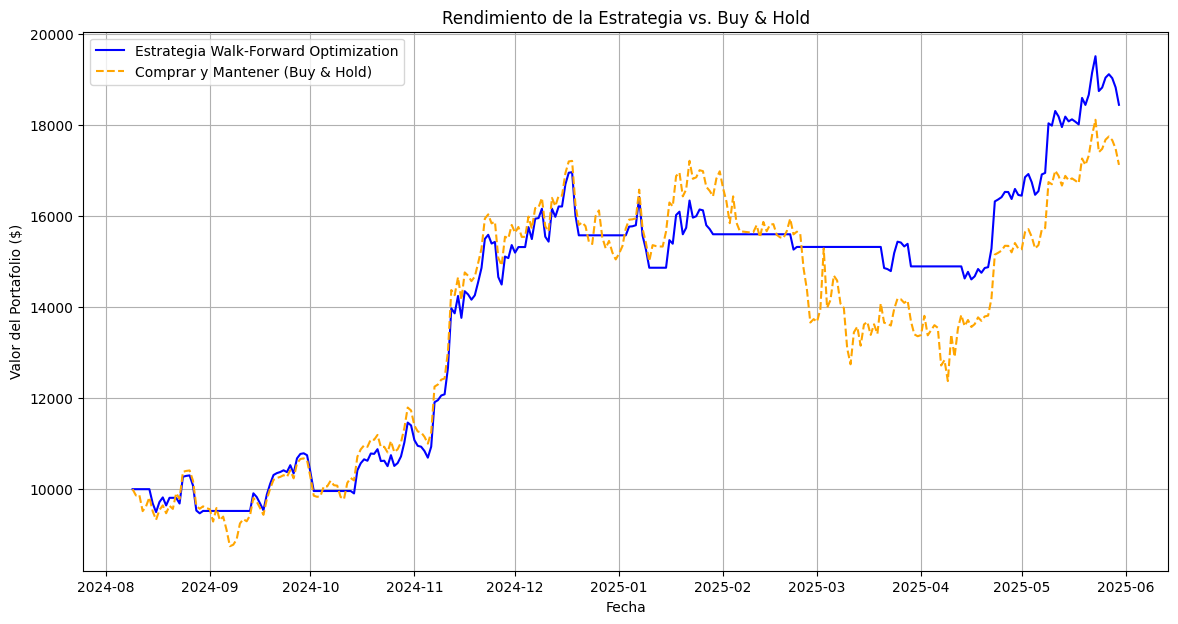

In [8]:
# 6. Visualización
plt.figure(figsize=(14, 7))
plt.plot(backtest_df['date'], backtest_df['portfolio_value'], label='Estrategia Walk-Forward Optimization', color='blue')

# Calcular la curva de Buy & Hold para la visualización
buy_and_hold_values = (backtest_df[price_col] / backtest_df[price_col].iloc[0]) * initial_capital
plt.plot(backtest_df['date'], buy_and_hold_values, label='Comprar y Mantener (Buy & Hold)', color='orange', linestyle='--')

plt.title('Rendimiento de la Estrategia vs. Buy & Hold')
plt.xlabel('Fecha')
plt.ylabel('Valor del Portafolio ($)')
plt.legend()
plt.grid(True)
plt.show()